In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mplsoccer import Pitch, VerticalPitch  
from pathlib import Path
import os
import json
import csv
from tqdm import tqdm
import logging
from dotenv import load_dotenv
from pathlib import Path
import os

load_dotenv()

DATA_ROOT = Path(os.environ["EXJOBB_DATA"])
sb_root = DATA_ROOT / "open-data-master" / "data"
matches_dir = sb_root / "matches"
events_dir  = sb_root / "events"
three_dir   = sb_root / "three-sixty"

assert three_dir.exists(), f"Missing: {three_dir}"


In [25]:
three_files = sorted(three_dir.glob("*.json"))
three_match_ids = sorted(int(p.stem) for p in three_files)

comps = pd.read_json(sb_root / "competitions.json")

rows = []
for mf in sorted(matches_dir.rglob("*.json")):
    comp_id = int(mf.parent.name)
    season_id = int(mf.stem)
    data = json.loads(mf.read_text())
    for m in data:
        if m["match_id"] in set(three_match_ids):
            rows.append({
                "competition_id": comp_id,
                "season_id": season_id,
                "match_id": m["match_id"],
                "match_date": m.get("match_date"),
                "home_team": m["home_team"]["home_team_name"],
                "away_team": m["away_team"]["away_team_name"],
                "home_team_id": m["home_team"]["home_team_id"],
                "away_team_id": m["away_team"]["away_team_id"],
            })

matches_360 = pd.DataFrame(rows).merge(
    comps[["competition_id","season_id","competition_name","season_name"]],
    on=["competition_id","season_id"],
    how="left",
)
print(matches_360.shape)
matches_360.head()

(326, 10)


,competition_id,season_id,match_id,match_date,home_team,away_team,home_team_id,away_team_id,competition_name,season_name
0,43,106,3857256,2022-12-02,Serbia,Switzerland,786,773,FIFA World Cup,2022
1,43,106,3869151,2022-12-03,Argentina,Australia,779,792,FIFA World Cup,2022
2,43,106,3857257,2022-11-30,Australia,Denmark,792,776,FIFA World Cup,2022
3,43,106,3857258,2022-11-24,Brazil,Serbia,781,786,FIFA World Cup,2022
4,43,106,3857288,2022-11-26,Tunisia,Australia,777,792,FIFA World Cup,2022


In [26]:
def load_json(path: Path):
    return json.loads(path.read_text())

def visible_area_area(vis):
    # polygon area of visible_area (flat [x1,y1,...] or nested [[x,y],...])
    if vis is None:
        return np.nan
    arr = np.asarray(vis, dtype=float)
    if arr.ndim == 1:
        if arr.size < 6 or arr.size % 2: 
            return np.nan
        pts = arr.reshape(-1,2)
    elif arr.ndim == 2 and arr.shape[1] == 2 and arr.shape[0] >= 3:
        pts = arr
    else:
        return np.nan
    x, y = pts[:,0], pts[:,1]
    return 0.5 * np.abs(np.dot(x, np.roll(y,-1)) - np.dot(y, np.roll(x,-1)))

def extract_freeze_points(rec):
    ff = rec.get("freeze_frame", [])
    if not isinstance(ff, list) or len(ff) == 0:
        return None

    xs, ys, teammate, actor, keeper = [], [], [], [], []
    for p in ff:
        loc = p.get("location")
        if not loc:
            continue
        xs.append(loc[0]); ys.append(loc[1])
        teammate.append(bool(p.get("teammate", False)))
        actor.append(bool(p.get("actor", False)))
        keeper.append(bool(p.get("keeper", False)))

    if len(xs) == 0:
        return None

    return {
        "x": np.array(xs, dtype=float),
        "y": np.array(ys, dtype=float),
        "teammate": np.array(teammate, dtype=bool),
        "actor": np.array(actor, dtype=bool),
        "keeper": np.array(keeper, dtype=bool),
    }

def lane_obstruction_features(x0, y0, x1, y1, opp_x, opp_y, lane_width=1.5):
    vx, vy = (x1 - x0), (y1 - y0)
    L2 = vx*vx + vy*vy
    if L2 < 1e-6 or len(opp_x) == 0:
        return {
            "min_opp_dist_to_lane": np.nan,
            f"n_opp_in_lane_{lane_width}": 0,
            f"lane_blocked_{lane_width}": 0,
        }

    wx = opp_x - x0
    wy = opp_y - y0

    t = (wx*vx + wy*vy) / L2
    between = (t >= 0.0) & (t <= 1.0)

    if not between.any():
        return {
            "min_opp_dist_to_lane": np.nan,
            f"n_opp_in_lane_{lane_width}": 0,
            f"lane_blocked_{lane_width}": 0,
        }

    t = np.clip(t, 0.0, 1.0)
    proj_x = x0 + t * vx
    proj_y = y0 + t * vy

    dist = np.sqrt((opp_x - proj_x)**2 + (opp_y - proj_y)**2)
    dist_between = dist[between]

    min_dist = float(dist_between.min())

    return {
        "min_opp_dist_to_lane": min_dist,
        f"n_opp_in_lane_{lane_width}": int((dist_between <= lane_width).sum()),
        f"lane_blocked_{lane_width}": int(min_dist <= lane_width),
    }



In [39]:
def compute_pass_features(ev, rec, R=17.0):
    pts = extract_freeze_points(rec)
    if pts is None:
        return None

    # actor location (from event if available; otherwise from freeze_frame actor)
    ev_loc = ev.get("location")
    if ev_loc is None:
        # fallback to actor point in freeze frame
        a_mask = pts["actor"]
        if not a_mask.any():
            return None
        x0, y0 = pts["x"][a_mask][0], pts["y"][a_mask][0]
    else:
        x0, y0 = float(ev_loc[0]), float(ev_loc[1])

    # label: pass end location (StatsBomb: ev["pass"]["end_location"])
    p = ev.get("pass")
    if not isinstance(p, dict) or p.get("end_location") is None:
        return None
    x1, y1 = p["end_location"]
    x1, y1 = float(x1), float(y1)

    # split teammates/opponents (excluding actor point from teammates set)
    tm = pts["teammate"].copy()
    op = ~tm
    # try exclude actor from teammate pool if it’s marked
    tm_actor = tm & pts["actor"]
    tm = tm & ~pts["actor"]

    opp_x = pts["x"][op]
    opp_y = pts["y"][op]





    dx = pts["x"] - x0
    dy = pts["y"] - y0
    d = np.sqrt(dx*dx + dy*dy)

    d_tm = d[tm] if tm.any() else np.array([])
    d_op = d[op] if op.any() else np.array([])

    feat = {
        "x_start": x0,
        "y_start": y0,
        "x_end": x1,     # label (keep for training)
        "y_end": y1,     # label

        "n_players_visible": len(pts["x"]),
        "n_teammates_visible": int(tm.sum()),
        "n_opponents_visible": int(op.sum()),

        "nearest_teammate_dist": float(d_tm.min()) if d_tm.size else np.nan,
        "nearest_opponent_dist": float(d_op.min()) if d_op.size else np.nan,

        f"teammates_within_{R}": int((d_tm <= R).sum()) if d_tm.size else 0,
        f"opponents_within_{R}": int((d_op <= R).sum()) if d_op.size else 0,

        "teammate_dist_mean": float(d_tm.mean()) if d_tm.size else np.nan,
        "opponent_dist_mean": float(d_op.mean()) if d_op.size else np.nan,

        "visible_area": float(visible_area_area(rec.get("visible_area"))),
    }
    lane_feats = lane_obstruction_features(
        x0, y0, x1, y1,
        opp_x, opp_y,
        lane_width=2.5
    )
    feat.update(lane_feats)

    # simple team “spread” features in absolute pitch coords
    if tm.any():
        feat["tm_x_std"] = float(np.std(pts["x"][tm]))
        feat["tm_y_std"] = float(np.std(pts["y"][tm]))
    else:
        feat["tm_x_std"] = np.nan
        feat["tm_y_std"] = np.nan

    if op.any():
        feat["op_x_std"] = float(np.std(pts["x"][op]))
        feat["op_y_std"] = float(np.std(pts["y"][op]))
    else:
        feat["op_x_std"] = np.nan
        feat["op_y_std"] = np.nan

    # optional metadata
    feat["match_id"] = int(ev.get("match_id", -1))  # may not exist in raw event dict
    feat["event_id"] = ev.get("id")
    feat["minute"] = ev.get("minute")
    feat["second"] = ev.get("second")
    feat["team_id"] = ev.get("team", {}).get("id") if isinstance(ev.get("team"), dict) else None
    feat["player_id"] = ev.get("player", {}).get("id") if isinstance(ev.get("player"), dict) else None

    return feat


In [40]:
def build_pass_dataset(sb_root, match_ids, limit_matches=None):
    out = []
    match_ids = match_ids[:limit_matches] if limit_matches else match_ids

    for i, mid in enumerate(match_ids, 1):
        events_path = sb_root / "events" / f"{mid}.json"
        three_path  = sb_root / "three-sixty" / f"{mid}.json"
        if not events_path.exists() or not three_path.exists():
            continue

        events = load_json(events_path)
        three  = load_json(three_path)

        # index 360 by event_uuid for fast join
        rec_by_uuid = {r["event_uuid"]: r for r in three if "event_uuid" in r}

        for ev in events:
            if ev.get("type", {}).get("name") != "Pass":
                continue
            uuid = ev.get("id")
            if uuid not in rec_by_uuid:
                continue

            feat = compute_pass_features(ev, rec_by_uuid[uuid], R=10.0)
            if feat is None:
                continue
            feat["match_id"] = mid  # ensure present
            out.append(feat)

        if i % 25 == 0:
            print(f"processed {i}/{len(match_ids)} matches, rows={len(out)}")

    return pd.DataFrame(out)

df = build_pass_dataset(sb_root, three_match_ids, limit_matches=20)  # start small
df.head(), df.shape


(   x_start  y_start  x_end  y_end  n_players_visible  n_teammates_visible  \
 0     60.0     40.0   32.5   28.8                 10                    3   
 1     36.2     30.4   70.7   75.8                 18                    9   
 2     43.1      0.1   15.8    7.5                 15                    7   
 3      3.3     12.7    7.9   36.2                  6                    4   
 4      9.1     38.9   19.7   47.9                 10                    6   
 
    n_opponents_visible  nearest_teammate_dist  nearest_opponent_dist  \
 0                    6               8.442516               8.700299   
 1                    8              11.121507               5.362913   
 2                    7              13.713861               9.050701   
 3                    1              18.359373              34.110872   
 4                    3              11.379301              29.491182   
 
    teammates_within_10.0  ...   tm_x_std   tm_y_std   op_x_std   op_y_std  \
 0          

In [41]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(df, groups=df["match_id"]))

train = df.iloc[train_idx].copy()
test  = df.iloc[test_idx].copy()

print(train.shape, test.shape)


(13820, 27) (3399, 27)


In [42]:
import numpy as np

def mean_l2_error(xp, yp, xt, yt):
    return float(np.mean(np.sqrt((xp-xt)**2 + (yp-yt)**2)))

err_A = mean_l2_error(test["x_start"], test["y_start"], test["x_end"], test["y_end"])
print("Baseline A (end=start) mean error:", err_A)
dx = (train["x_end"] - train["x_start"]).mean()
dy = (train["y_end"] - train["y_start"]).mean()

x_pred = test["x_start"] + dx
y_pred = test["y_start"] + dy

err_B = mean_l2_error(x_pred, y_pred, test["x_end"], test["y_end"])
print("Baseline B (mean delta) mean error:", err_B)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor

X_cols_event_only = ["x_start", "y_start", "minute", "second"]
y_cols = ["x_end", "y_end"]

X_train = train[X_cols_event_only]
X_test  = test[X_cols_event_only]
y_train = train[y_cols]
y_test  = test[y_cols]

model_event = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("reg", MultiOutputRegressor(Ridge(alpha=1.0)))
])

model_event.fit(X_train, y_train)
pred = model_event.predict(X_test)

err_C = mean_l2_error(pred[:,0], pred[:,1], y_test["x_end"], y_test["y_end"])
print("Baseline C (Ridge, event-only) mean error:", err_C)



Baseline A (end=start) mean error: 20.173383678723
Baseline B (mean delta) mean error: 19.73344759818979
Baseline C (Ridge, event-only) mean error: 18.975461984416516


In [44]:
X_cols_360 = [
    "x_start","y_start","minute","second",
    "nearest_opponent_dist","nearest_teammate_dist",
    "opponents_within_10.0","teammates_within_10.0",
    "opponent_dist_mean","teammate_dist_mean",
    "op_x_std","op_y_std","tm_x_std","tm_y_std",
    "visible_area",
    "n_opponents_visible","n_teammates_visible","n_players_visible",
    "min_opp_dist_to_lane",
    "n_opp_in_lane_2.5",
    "lane_blocked_2.5",
]

X_train = train[X_cols_360]
X_test  = test[X_cols_360]

model_360 = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("reg", MultiOutputRegressor(Ridge(alpha=1.0)))
])

model_360.fit(X_train, y_train)
pred = model_360.predict(X_test)

err_D = mean_l2_error(pred[:,0], pred[:,1], y_test["x_end"], y_test["y_end"])
print("Baseline D (Ridge, +360) mean error:", err_D)


Baseline D (Ridge, +360) mean error: 17.75402330306074


In [47]:

_three_cache = {}
_events_cache = {}

def _load_three_for_match(sb_root, match_id):
    if match_id not in _three_cache:
        path = sb_root / "three-sixty" / f"{match_id}.json"
        three = json.loads(path.read_text())
        _three_cache[match_id] = {r["event_uuid"]: r for r in three if "event_uuid" in r}
    return _three_cache[match_id]

def _load_events_for_match(sb_root, match_id):
    if match_id not in _events_cache:
        path = sb_root / "events" / f"{match_id}.json"
        events = json.loads(path.read_text())
        _events_cache[match_id] = {e["id"]: e for e in events if "id" in e}
    return _events_cache[match_id]

def _visible_area_xy(vis):
    if vis is None:
        return None
    arr = np.asarray(vis, dtype=float)
    if arr.ndim == 1:
        if arr.size >= 6 and arr.size % 2 == 0:
            return arr.reshape(-1, 2)
        return None
    if arr.ndim == 2 and arr.shape[1] == 2 and arr.shape[0] >= 3:
        return arr
    return None

def plot_pass_with_freeze_frame(sb_root, row, show_visible_area=True, figsize=(9, 6)):
    match_id = int(row["match_id"])
    event_id = row["event_id"]

    rec_by_uuid = _load_three_for_match(sb_root, match_id)
    rec = rec_by_uuid.get(event_id)
    if rec is None:
        raise ValueError("No 360 record for this event_id (shouldn't happen if you filtered correctly).")

    # (optional) event for title
    ev_by_id = _load_events_for_match(sb_root, match_id)
    ev = ev_by_id.get(event_id, {})
    ev_type = ev.get("type", {}).get("name", "Event")
    minute = ev.get("minute", row.get("minute", "?"))
    second = ev.get("second", row.get("second", "?"))

    pitch = Pitch(pitch_type="statsbomb")
    fig, ax = pitch.draw(figsize=figsize)

    # --- visible area polygon
    if show_visible_area:
        vis_xy = _visible_area_xy(rec.get("visible_area"))
        if vis_xy is not None:
            pitch.polygon([vis_xy], ax=ax, alpha=0.12)
            pitch.plot(vis_xy[:, 0], vis_xy[:, 1], ax=ax, linewidth=1)

    # --- players
    ff = rec.get("freeze_frame", [])
    if isinstance(ff, list) and len(ff) > 0:
        xs, ys, tm, actor, keeper = [], [], [], [], []
        for p in ff:
            loc = p.get("location")
            if not loc:
                continue
            xs.append(loc[0]); ys.append(loc[1])
            tm.append(bool(p.get("teammate", False)))
            actor.append(bool(p.get("actor", False)))
            keeper.append(bool(p.get("keeper", False)))

        xs = np.array(xs, dtype=float)
        ys = np.array(ys, dtype=float)
        tm = np.array(tm, dtype=bool)
        actor = np.array(actor, dtype=bool)
        keeper = np.array(keeper, dtype=bool)
        op = ~tm

        # teammates (circles) and opponents (squares)
        if tm.any():
            pitch.scatter(xs[tm], ys[tm], ax=ax, s=110, marker="o", edgecolors="black", linewidth=0.8, zorder=3)
        if op.any():
            pitch.scatter(xs[op], ys[op], ax=ax, s=110, marker="s", edgecolors="black", linewidth=0.8, zorder=3)

        # highlight keeper(s) (triangles)
        if keeper.any():
            pitch.scatter(xs[keeper], ys[keeper], ax=ax, s=160, marker="^", edgecolors="black", linewidth=0.8, zorder=4)

        # highlight actor (ring)
        if actor.any():
            pitch.scatter(xs[actor], ys[actor], ax=ax, s=320, facecolors="none", edgecolors="black", linewidth=2, zorder=5)

    # --- pass arrows
    x0, y0 = float(row["x_start"]), float(row["y_start"])
    x1, y1 = float(row["x_end"]), float(row["y_end"])
    xp, yp = float(row["x_pred"]), float(row["y_pred"])

    pitch.arrows(x0, y0, x1, y1, ax=ax, width=2.2, headwidth=6, headlength=6, color="black", label="Actual", zorder=6)
    pitch.arrows(x0, y0, xp, yp, ax=ax, width=2.2, headwidth=6, headlength=6, color="red", linestyle="dashed", label="Predicted", zorder=6)

    pitch.scatter(x0, y0, ax=ax, s=60, color="blue", zorder=7)

    err = np.sqrt((xp - x1)**2 + (yp - y1)**2)
    ax.set_title(f"{ev_type} | {minute}:{int(second):02d} | match {match_id} | error {err:.1f}m")
    ax.legend(loc="upper left")
    plt.show()
    return fig, ax


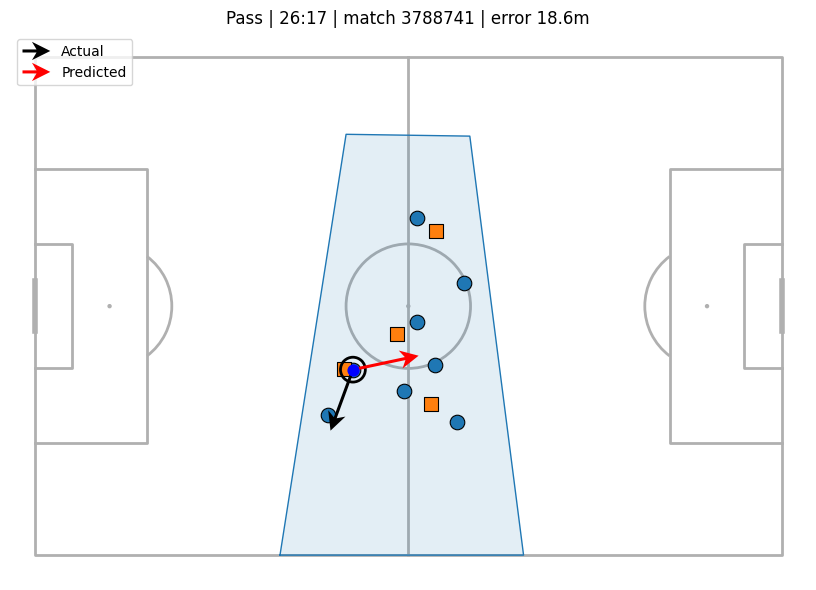

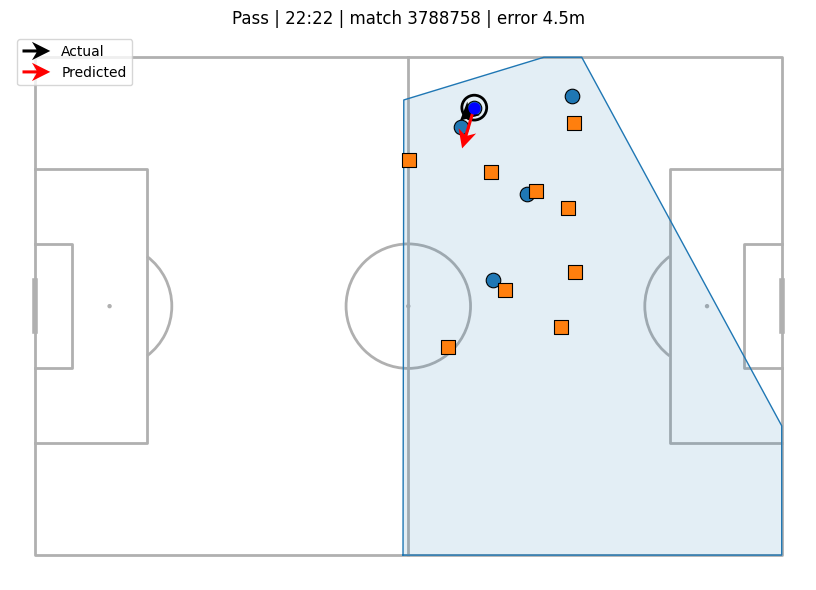

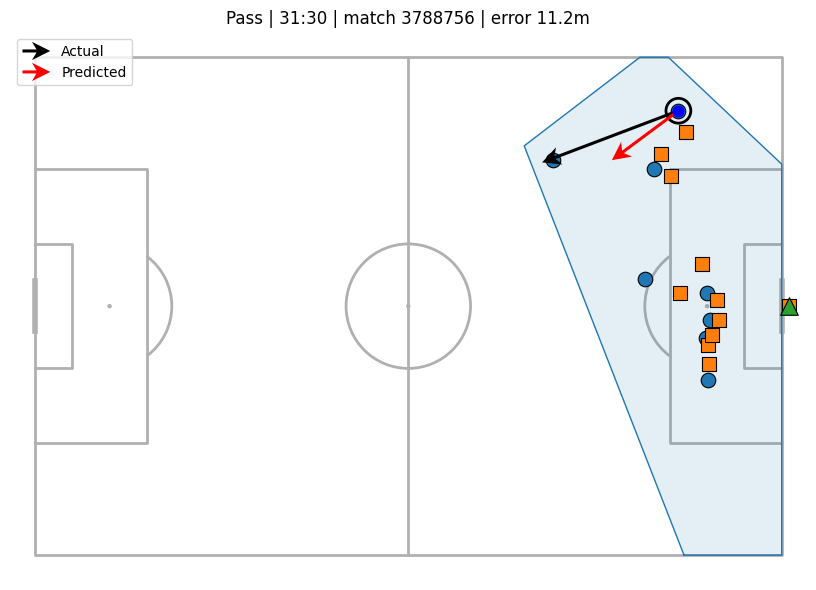

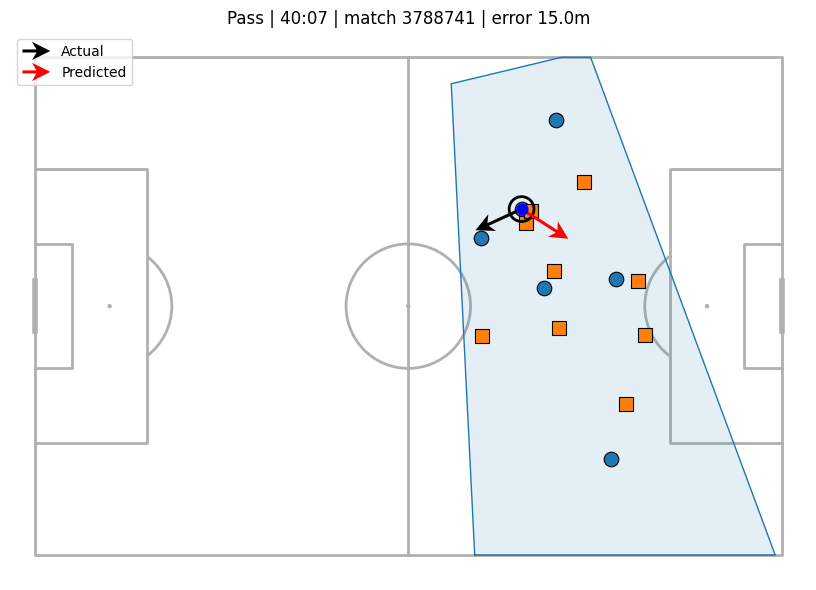

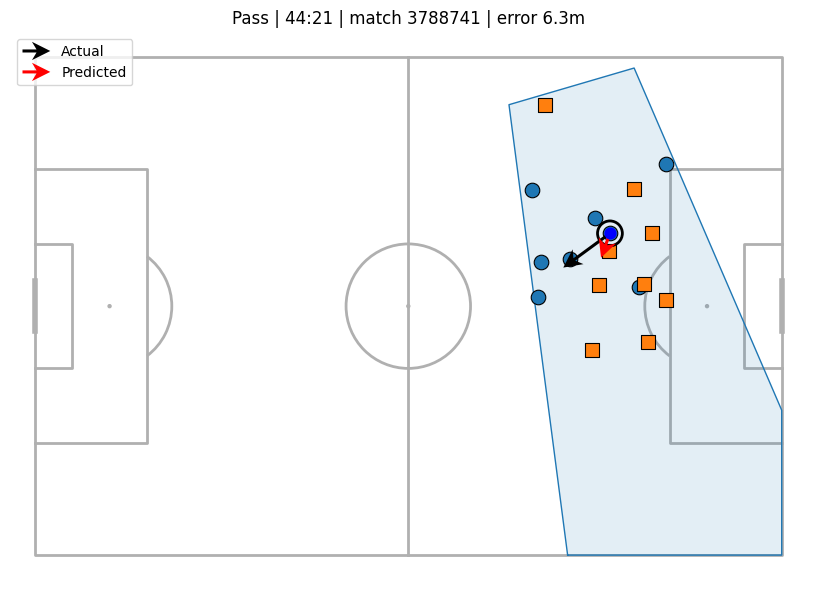

In [48]:
# test_vis must already include x_pred/y_pred and event_id/match_id
for _, row in test_vis.sample(5, random_state=42).iterrows():
    plot_pass_with_freeze_frame(sb_root, row)



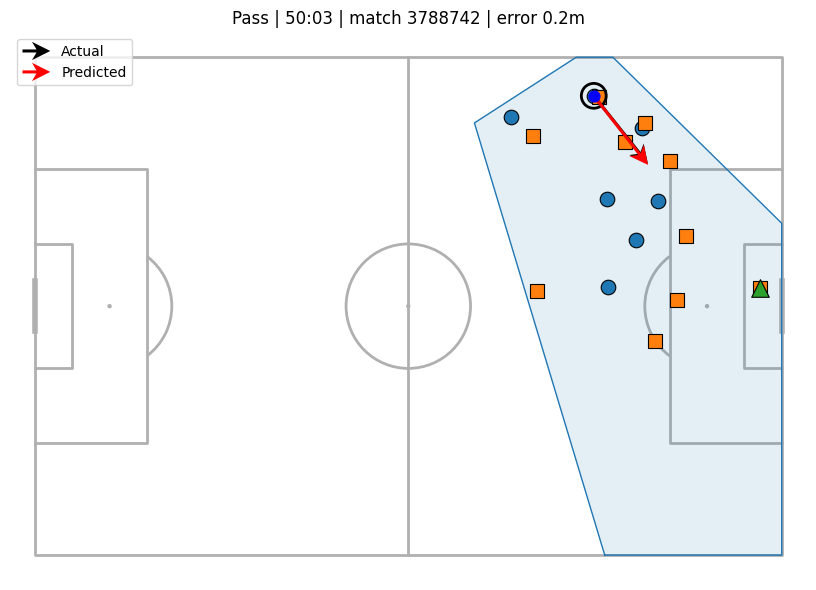

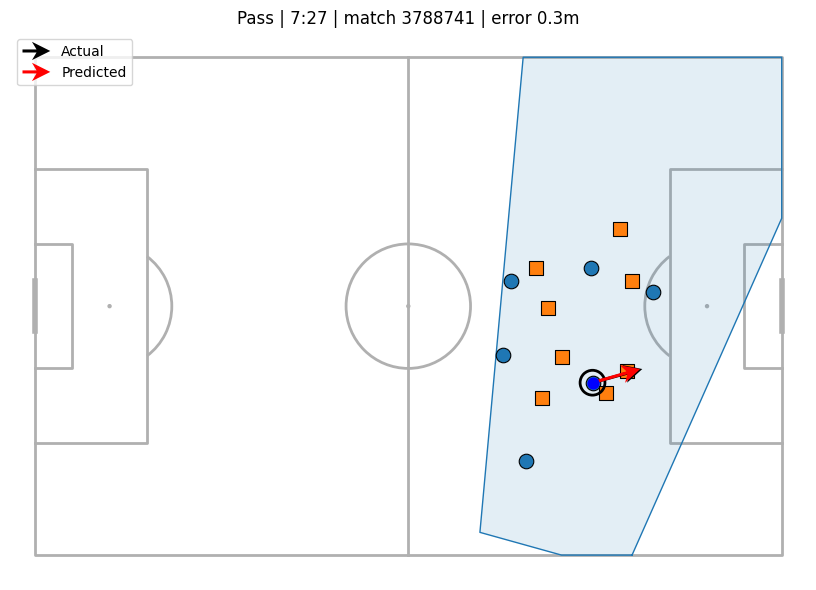

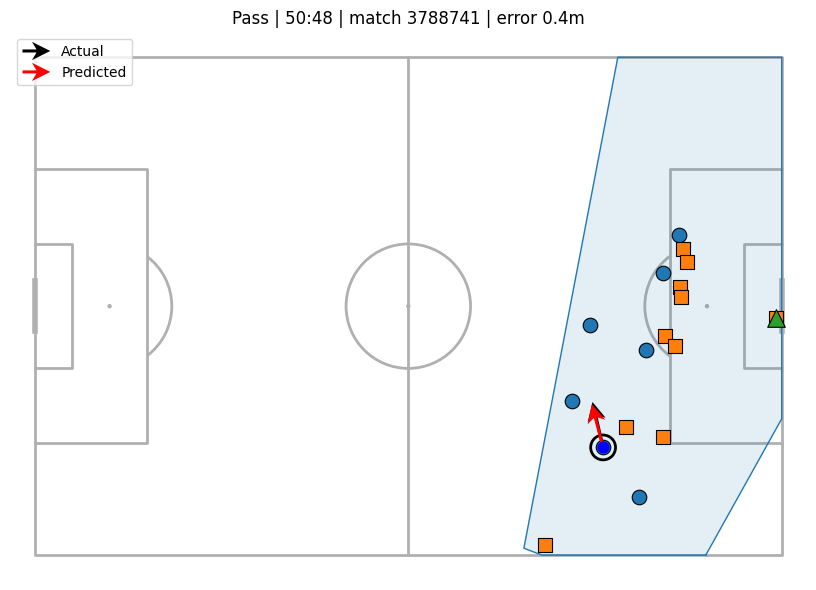

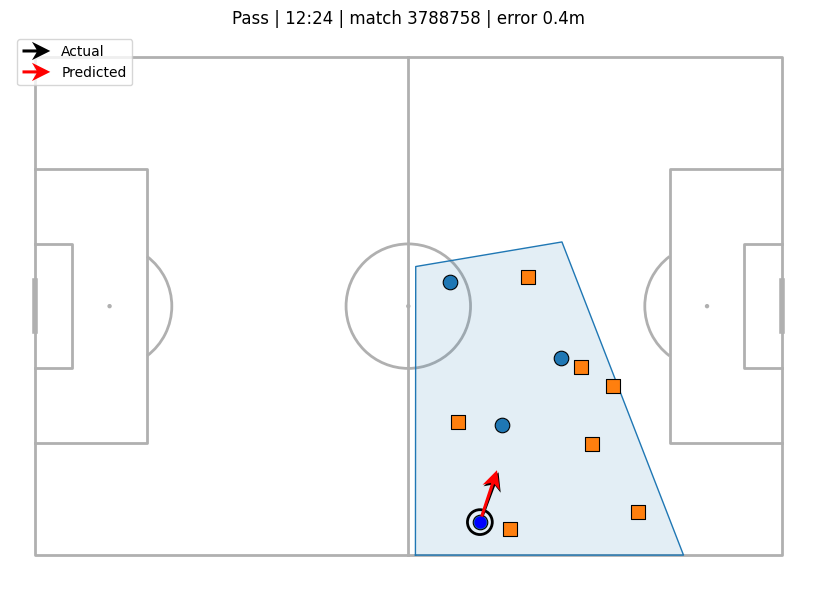

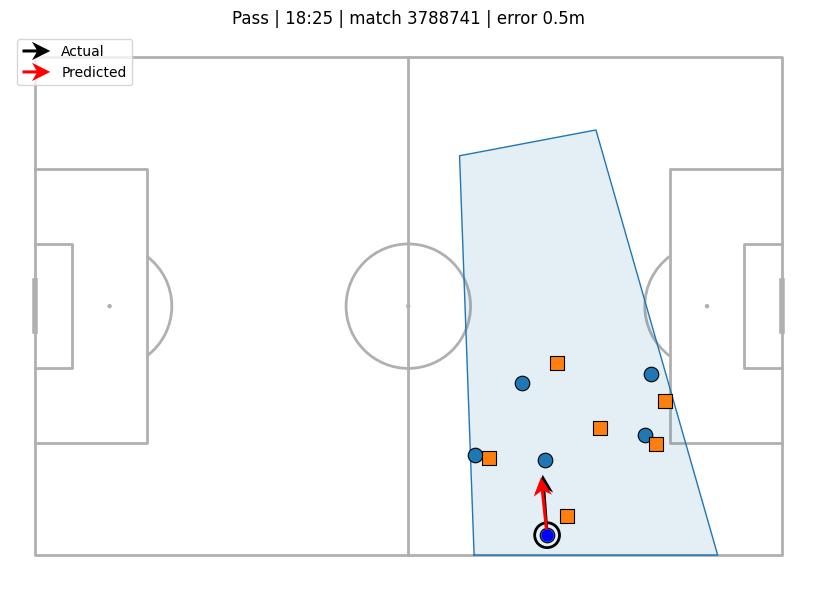

In [50]:
err = np.sqrt((test_vis["x_pred"]-test_vis["x_end"])**2 + (test_vis["y_pred"]-test_vis["y_end"])**2)
worst = test_vis.assign(err=err).sort_values("err", ascending=True).head(5)

for _, row in worst.iterrows():
    plot_pass_with_freeze_frame(sb_root, row)
